In [2]:
import torch 
import numpy as np
import pandas as pd
import random
import os
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import albumentations as A

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
from tqdm.notebook import tqdm
import cv2

In [3]:
#参数设置
def set_seed(seed) : 
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [4]:
class config() : 
    input_ch = 3
    train_rate = 0.8
    val_rate = 0.2
    img_size = 224 # wrong
    output_ch = 1
    seed = 127
    biggest_loss = 1e6
    data_dir = 'D:\\ML_data_sql\\brain\\brain_seg'
    #TODO
    model_path = 'unet_best.pt'

    batch_size = 32
    lr = 5e-3 # 3e-3
    num_epochs =  2 # 300
    patience_lr_reducing = 5
    cut_threshold = 0.3
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    steps = 10 

In [5]:
set_seed(config.seed)
old_settings = np.seterr(all='warn', over='raise') #raise 

In [6]:
def path_walk(path) : 
    dirs, images, df = [], [], []
    for dir_path, _, names in os.walk(path) : 
        for mask_name in names : 
            if mask_name.endswith('_mask.tif') : 
                img_name = mask_name[:-9] + '.tif'
                img_path = dir_path + '/' + img_name
                mask_path = dir_path + '/' + mask_name
                
                row = [img_path, mask_path, 1 if np.max(Image.open(mask_path)) > 0 else 0]
                
                df.append(row)
    df = pd.DataFrame(np.array(df), columns=['img_dir', 'mask_dir', 'diag'])
    df.astype('str')    
    df['diag'] = df['diag'].astype('int')
    df = df.sample(frac=1).reset_index(drop=True)
    return df
df = path_walk(config.data_dir)

In [7]:
df_0 = df[df['diag'] == 0]
df_1 = df[df['diag'] == 1]
len_0 = len(df_0)
len_1 = len(df_1)
print(len_0, len_1)

5112 2746


In [8]:
lim_0 = int(config.train_rate * len_0)
lim_1 = int(config.train_rate * len_1)
train_0 = df_0[:lim_0]
val_0 = df_0[lim_0:]
train_1 = df_1[:lim_1]
val_1 = df_1[lim_1:]

training_df = pd.concat([train_0, train_1], ignore_index=True)
validation_df = pd.concat([val_0, val_1], ignore_index=True)

In [9]:
print(len(training_df))
print(len(validation_df))

6285
1573


(256, 256)


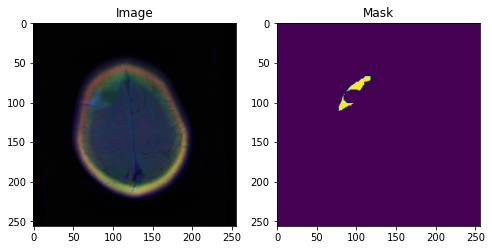

In [10]:
def plot_example(img_path, mask_path):
    img = Image.open(img_path)
    mask = Image.open(mask_path)

    print(img.size)
    
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(img)
    ax[0].set_title('Image')
    ax[1].imshow(mask) 
    ax[1].set_title('Mask')
    plt.show()
plot_example(training_df.loc[4444,'img_dir'], training_df.loc[4444,'mask_dir'])

In [11]:
class BrainMRIDataset(Dataset) : 
    def __init__(self, df, transforms=None) : 
        super(BrainMRIDataset, self).__init__() 
        self.df = df
        self.transforms = transforms
    def __len__(self) : 
        return self.df.shape[0]
    def __getitem__(self, index) :
        image = cv2.imread(self.df.iloc[index, 0]) # image
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[index, 1], 0) # mask, read in grayscale mode
        mask = np.array(mask)/255.
        
        if self.transforms is not None:
            aug = self.transforms(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
        
        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1)) # read in grayscale mode, so we need to expand the dims
        mask = torch.from_numpy(mask).type(torch.float32)
        return image, mask

In [12]:
train_transforms = A.Compose([
    A.Resize(width = config.img_size, height = config.img_size, p = 1.0), # p is probability
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit = 0.01, scale_limit = 0.04, rotate_limit = 0, p=0.25)
])
val_transforms = A.Compose([
    A.Resize(width = config.img_size, height = config.img_size, p = 1.0), # p is probability
])
training_set = BrainMRIDataset(training_df, train_transforms)
validation_set = BrainMRIDataset(validation_df, val_transforms)
training_dataloader = DataLoader(training_set, 
                                 config.batch_size, 
                                 num_workers=2,
                                 pin_memory = True
                                )
validation_dataloader = DataLoader(validation_set,
                                   config.batch_size, 
                                   num_workers=2, 
                                   pin_memory = True 
                                  )
# print(len(training_dataloader))

In [13]:
def dice_coef_metric(pred, label) : 
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

def dice_coef_loss(pred, label) :
    smooth_coef = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth_coef
    union = pred.sum() + label.sum() + smooth_coef
    return 1 - (intersection / union)
def dice_bce_loss(pred, label) : 
    bce_loss = torch.nn.BCELoss()(pred, label)
    dice_loss = dice_coef_loss(pred, label)
    return bce_loss + dice_loss

In [14]:
from Unet import UNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=1).to(config.device)
trainable_parameters = [param for param in model.parameters() if param.requires_grad == True]
# optimizer = torch.optim.Adam(trainable_parameters, lr = config.lr)
optimizer = torch.optim.SGD(trainable_parameters, lr = config.lr, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience = config.patience_lr_reducing)
training_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config.steps)

In [ ]:
def training_progress(training_loader, loss_func, dice_func, training_lr_scheduler, threshold):
    model.train()
    training_losses, training_dices = [], []
    
    training_loader = tqdm(training_loader, desc="Iteration through training set")
    
    for image, mask in training_loader : 
        image = image.to(config.device)
        mask = mask.to(config.device)
        
        output = model(image)
        
        out_cut = np.copy(output.data.cpu().numpy())
        out_cut[out_cut < config.cut_threshold] = 0.0 # faster calculation for sparse tensor
        out_cut[out_cut >= config.cut_threshold] = 1.0
        
        loss = loss_func(output, mask) # tensor tensor
        dice = dice_func(out_cut, mask.data.cpu().numpy()) # numpy array numpy array
        
        training_losses.append(loss.item()) # one element tensor will be convert to standard python number
        training_dices.append(dice)
        
        optimizer.zero_grad() # set gradient to zero
        loss.backward() # back propagation
        optimizer.step() # gradient descent, update the parameters
        training_lr_scheduler.step()
        
    mean_losses = np.array(training_losses).mean()
    mean_dices = np.array(training_dices).mean()
    print(mean_losses)
    return mean_losses, mean_dices

In [ ]:
def evaluation_progress(validation_loader, loss_func, dice_func, threshold, scheduler, training=False):
    model.eval()
    validation_loss = 0 
    validation_dice = 0
    
    validation_loader = tqdm(validation_loader, "Iteration through validation set")
    cnt = 0
    with torch.no_grad() : 
        for image, mask in validation_loader : 
            image = image.to(config.device)
            mask = mask.to(config.device)
            
            output = model(image)
            
            out_cut = output.data.cpu().numpy()
            out_cut[out_cut < config.cut_threshold] = 0.0
            out_cut[out_cut >= config.cut_threshold] = 1.0

            validation_loss += loss_func(output, mask)
            validation_dice += dice_func(out_cut, mask.data.cpu().numpy())
            
            cnt+=1
    validation_loss/=cnt
    validation_dice/=cnt
    if training:
        scheduler.step(validation_loss) # why they use dice instead of loss
    return validation_loss, validation_dice

In [ ]:
def training_model(model, training_loader, validation_loader, loss_func, dice_func, scheduler, training_lr_scheduler, threshold=0.5) : 
    bestmodel_loss = config.biggest_loss
    training_losses_history, training_dices_history, validation_losses_history, validation_dices_history = [], [], [], []
    for epoch in range(config.num_epochs) : 
        training_loss, training_dice = training_progress(training_loader, loss_func, dice_func, training_lr_scheduler, threshold)
        validation_loss, validation_dice = evaluation_progress(validation_loader, loss_func, dice_func, threshold, scheduler) 
        
        training_losses_history.append(training_loss)
        training_dices_history.append(training_dice)        
        validation_losses_history.append(validation_loss)
        validation_dices_history.append(validation_dice)
        
        print(f'Epoch {epoch + 1}/{config.num_epochs} | Training_loss : {training_loss:.3f} | Validation_loss : {validation_loss:.3f} | Training_dice : {training_dice:.3f} | Validation_dice : {validation_dice:.3f} '  )
        
        if validation_loss < bestmodel_loss : 
            bestmodel_loss = validation_loss
            torch.save(model.state_dict(), 'unet_best.pt')
    return training_losses_history, training_dices_history, validation_losses_history, validation_dices_history   

In [17]:
training_losses_history, training_dices_history, validation_losses_history, validation_dices_history = training_model(model, training_dataloader, validation_dataloader, dice_bce_loss, dice_coef_metric, scheduler, training_lr_scheduler, threshold=config.cut_threshold)

In [ ]:
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE', lw=3)
    plt.plot(x, val_dice_history, label='Validation DICE', lw=3)

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()
    
plot_dice_history('ResNet50-backbone UNet', training_dices_history, validation_dices_history, config.num_epochs)